# Customer Segmentation
- This project uses the same data as previous Customer Segmentation, but performs RFM-based clustering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
marketing_df_org = pd.read_csv('C:/Users/pbyim/OneDrive/바탕 화면/시온/Data/marketing_campaign.csv', sep='\t')
marketing_df = marketing_df_org.copy()
marketing_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### RFM-based customer segmentation

In [6]:
rfm = marketing_df[['ID']].copy()
rfm['Recency'] = marketing_df['Recency']
rfm['Frequency'] = marketing_df[
    ['NumDealsPurchases','NumStorePurchases','NumWebPurchases','NumCatalogPurchases']
].sum(axis=1)
rfm['Monetary'] = marketing_df[
    ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
].sum(axis=1)
rfm.head()

,ID,Recency,Frequency,Monetary
0,5524,58,25,1617
1,2174,38,6,27
2,4141,26,21,776
3,6182,26,8,53
4,5324,94,19,422


In [8]:
marketing_df.shape

(2240, 29)

In [12]:
rfm.shape

(2240, 4)

- Every row is an individual customer

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [17]:
scaler = StandardScaler()
rfm_features_to_scale = rfm[['Recency','Frequency','Monetary']]
rfm_scaled = scaler.fit_transform(rfm_features_to_scale)

In [19]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_Scaled','Frequency_Scaled','Monetary_Scaled'], index=rfm.index)
rfm_scaled_df.head()

,Recency_Scaled,Frequency_Scaled,Monetary_Scaled
0,0.307039,1.320826,1.679417
1,-0.383664,-1.154596,-0.961275
2,-0.798086,0.799685,0.282673
3,-0.798086,-0.894025,-0.918094
4,1.550305,0.539114,-0.305254


- Find the optimal number of clusters (Elbow Method)

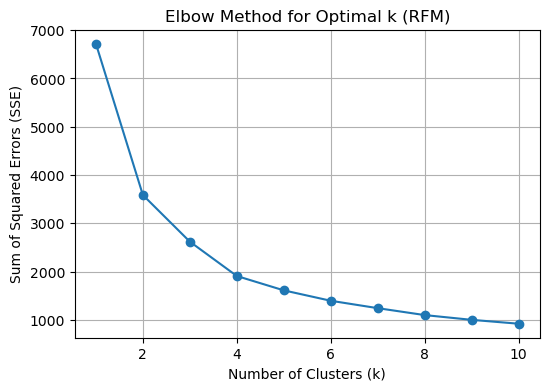

In [22]:
sse = []
k_range = range(1, 11) # Test the number of clusters from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k (RFM)')
plt.grid(True)
plt.show()

- Since "the elbow" where the SSE decrease flattens out sharply is located around k=4, we can use the the optimal number of clusters as 4

In [25]:
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(rfm_scaled_df)

rfm['Cluster'] = cluster_labels

print("Number of data per cluster:")
print(rfm['Cluster'].value_counts())

Number of data per cluster:
Cluster
3    606
0    580
2    552
1    502
Name: count, dtype: int64


In [27]:
cluster_summary = rfm.groupby('Cluster').agg(
    Count=('ID','count'),
    Avg_Recency=('Recency','mean'),
    Avg_Frequency=('Frequency','mean'),
    Avg_Monetary=('Monetary','mean')
).round(1)

print("RFM-based cluster summary")
print(cluster_summary)

print("\nRFM sample data (with clusters)")
print(rfm.head())

RFM-based cluster summary
         Count  Avg_Recency  Avg_Frequency  Avg_Monetary
Cluster                                                 
0          580         74.9            9.0         138.5
1          502         22.9           21.9        1115.1
2          552         72.8           21.5        1158.7
3          606         24.6            8.6         127.5

RFM sample data (with clusters)
     ID  Recency  Frequency  Monetary  Cluster
0  5524       58         25      1617        2
1  2174       38          6        27        3
2  4141       26         21       776        1
3  6182       26          8        53        3
4  5324       94         19       422        2


- Evaluating silhouette scores

In [30]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [32]:
silhouette_avg_rfm = silhouette_score(rfm_scaled_df, rfm['Cluster'])
print(f"RFM K-Means Average Silhouette Score: {silhouette_avg_rfm:.4f}")

# silhouette_samples: compute silhouette coefficients for each data point
silhouette_vals_rfm = silhouette_samples(rfm_scaled_df, rfm['Cluster'])

# Add the calculated silhouette coefficients to the original RFM DataFrame (for analysis)
rfm['Silhouette_Coef'] = silhouette_vals_rfm

# Calculate and print the average silhouette score per cluster
print("Average Silhouette Score by Cluster:")
# Group by Cluster in rfm DataFrame and calculate average for Silhouette_Coef
print(rfm.groupby('Cluster')['Silhouette_Coef'].mean())

RFM K-Means Average Silhouette Score: 0.3773
Average Silhouette Score by Cluster:
Cluster
0    0.445850
1    0.290518
2    0.296687
3    0.456930
Name: Silhouette_Coef, dtype: float64


#### Visualization

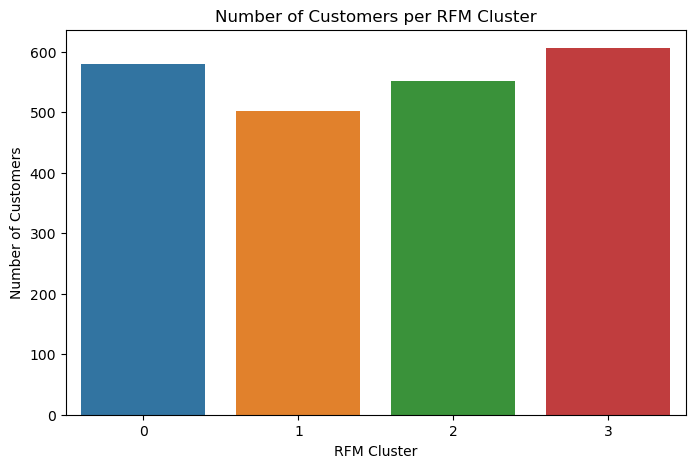

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=rfm)
plt.title('Number of Customers per RFM Cluster')
plt.xlabel('RFM Cluster')
plt.ylabel('Number of Customers')
plt.show()

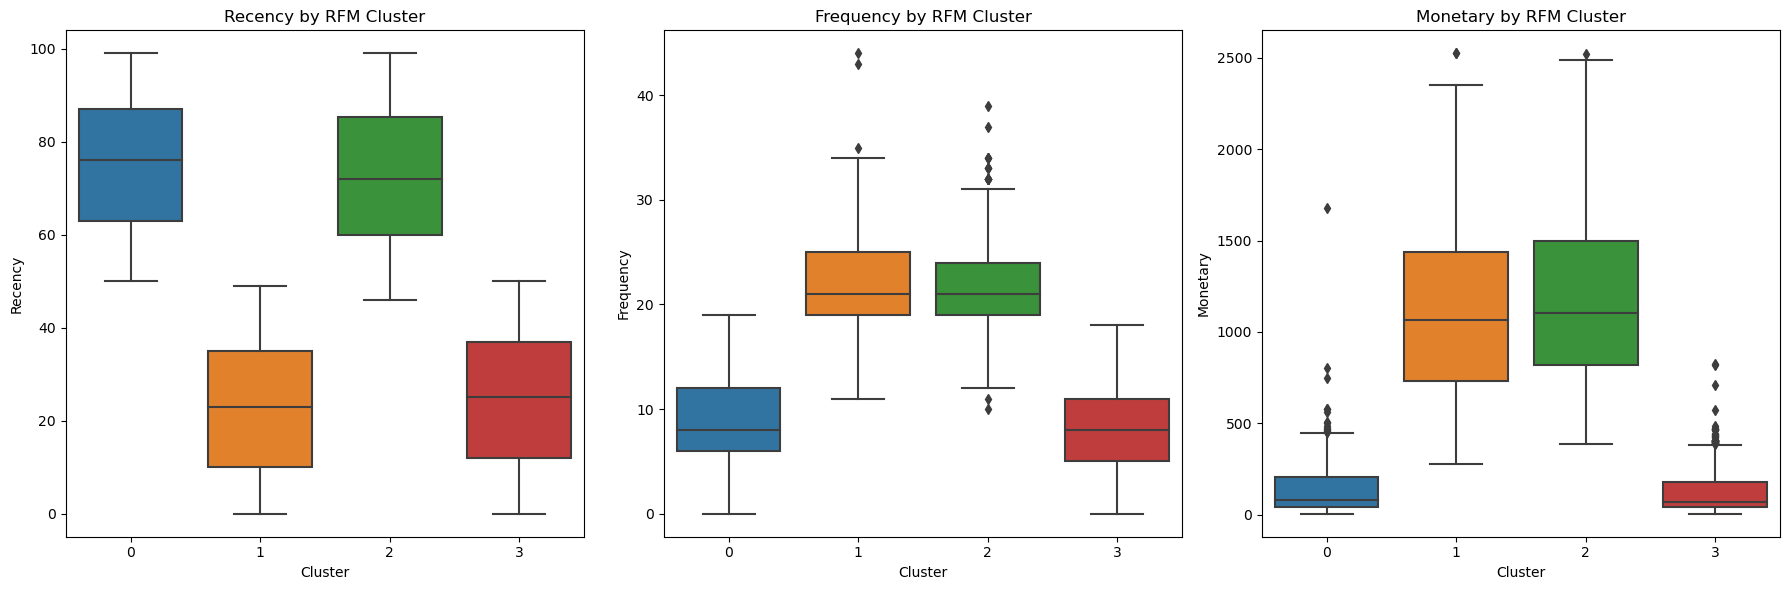

In [42]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)

sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0])
axes[0].set_title('Recency by RFM Cluster')

sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1])
axes[1].set_title('Frequency by RFM Cluster')

sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2])
axes[2].set_title('Monetary by RFM Cluster')

plt.tight_layout()
plt.show()

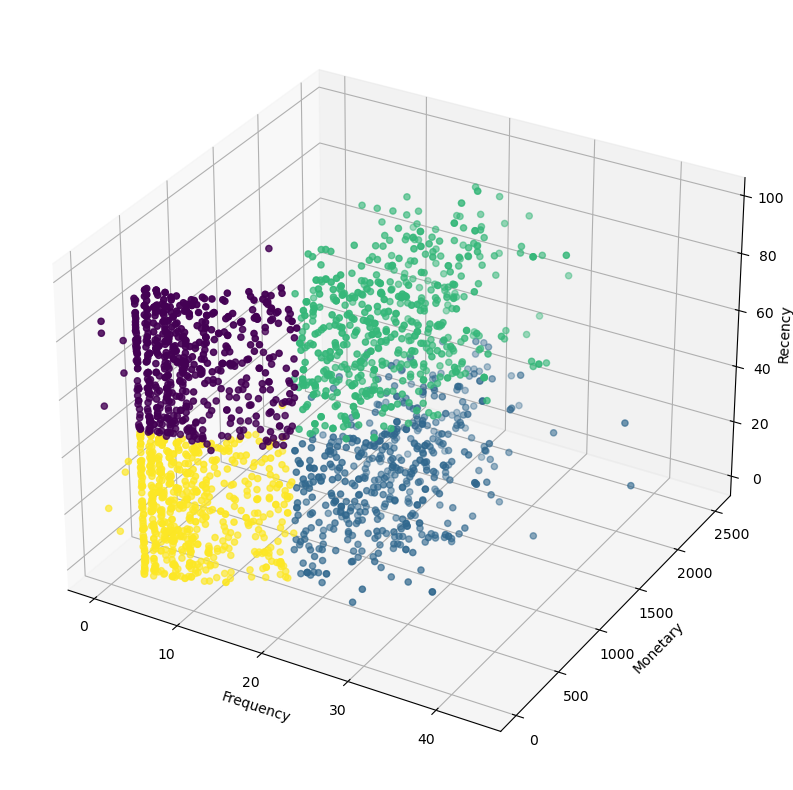

In [74]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(rfm['Frequency'], rfm['Monetary'], rfm['Recency'], c=rfm['Cluster'], marker="o" )
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency', labelpad=0)
plt.tight_layout()
plt.show()

In [90]:
print("\n--- RFM analysis summary ---")

for i in range(4):
    print(f"\nCluster {i}:")
    recency_avg = cluster_summary.loc[i, 'Avg_Recency']
    freq_avg = cluster_summary.loc[i, 'Avg_Frequency']
    monetary_avg = cluster_summary.loc[i, 'Avg_Monetary']

    total_avg = rfm[['Recency', 'Frequency', 'Monetary']].mean()

    r_ftr = ("Recently have purchase activities (Low Recency)" if recency_avg < total_avg['Recency'] 
             else "Recently no purchase activities (High Recency)")
    f_ftr = "High purchase frequency" if freq_avg > total_avg['Frequency'] else "Low purchase frequency"
    m_ftr = "High purchase amount (High Monetary)" if monetary_avg > total_avg['Monetary'] else "Low purchase amount(Low Monetary)"

    print(f"  - Features: {r_ftr}, {f_ftr}, {m_ftr}")
    print(f"  - Average R={recency_avg}, F={freq_avg}, M={monetary_avg}")


--- RFM analysis summary ---

Cluster 0:
  - Features: Recently no purchase activities (High Recency), Low purchase frequency, Low purchase amount(Low Monetary)
  - Average R=74.9, F=9.0, M=138.5

Cluster 1:
  - Features: Recently have purchase activities (Low Recency), High purchase frequency, High purchase amount (High Monetary)
  - Average R=22.9, F=21.9, M=1115.1

Cluster 2:
  - Features: Recently no purchase activities (High Recency), High purchase frequency, High purchase amount (High Monetary)
  - Average R=72.8, F=21.5, M=1158.7

Cluster 3:
  - Features: Recently have purchase activities (Low Recency), Low purchase frequency, Low purchase amount(Low Monetary)
  - Average R=24.6, F=8.6, M=127.5


#### Propose possible strategies based on RFM analysis
- Cluster 0: Dormant, low-margin customers
  - Key challenges: Encourage return visits and increase spending
  - Possible strategies: Reminder emails/texts, Offer a variety of small-quantity to-do coupons

<be>

- Cluster 1: High-margin loyalty customers
  - Key challenges: Maintain visits and spending
  - Possible strategies: VIP programs, priority access to new products, and enhanced loyalty rewards

<be>

- Cluster 2: High-margin churn risk customers
  - Key challenges: Immediate retention
  - Possible strategies: Offer short-term, high-percentage discount coupons, provide personalized service to resolve complaints

<be>

- Cluster 3: New, potential higher-margin customers
  - Key challenges: Drive long-term return visits, increase spending
  - Possible strategies: Run a promotion to encourage purchases, offer a post-purchase discount coupon to encourage return visits